In [1]:
!pip install pybaseball pandas numpy xgboost scikit-learn

Import Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pybaseball import batting_stats
import joblib

Step 1: Pull 2010-2023 Batting Stats

In [3]:
# Get batting stats for multiple years (2015-2023)
years = list(range(2015, 2024))
batting_data = pd.concat([batting_stats(y) for y in years], ignore_index=True)

# Select key batting metrics (adding new high-impact features)
batting_features = [
    "IDfg", "Season", "wOBA", "xwOBA", "ISO+", "EV", "HardHit%", "WPA", "REW", "OBP", "SLG", "ISO", "Age",
    "WPA/LI", "Off", "xSLG", "wRAA", "RE24", "maxEV",  # Existing features
    "BB%", "K%", "Spd"  # New features for feature engineering
]

# Keep only relevant columns
batting_data = batting_data[batting_features]

# Rename columns to match expected format
batting_data.rename(columns={
    "IDfg": "player_id",
    "Season": "year",
    "HardHit%": "hard_hit_rate",
    "maxEV": "max_exit_velocity",
    "BB%": "bb_rate",
    "K%": "k_rate",
    "Spd": "speed_score"
}, inplace=True)

# Ensure correct data types
batting_data["year"] = batting_data["year"].astype(int)

print(f"✅ Pulled batting stats from {years[0]} to {years[-1]} (Statcast Era)")
print(f"✅ Dataset Shape After Filtering: {batting_data.shape}")
print(batting_data.head())


✅ Pulled batting stats from 2015 to 2023 (Statcast Era)
✅ Dataset Shape After Filtering: (1246, 22)
   player_id  year   wOBA  xwOBA  ISO+    EV  hard_hit_rate   WPA   REW  \
0      11579  2015  0.461  0.418   213  91.4          0.477  6.18  8.04   
1      10155  2015  0.415  0.422   185  92.9          0.486  5.16  5.48   
2       5038  2015  0.398  0.390   172  92.5          0.465  6.10  6.09   
3       4314  2015  0.427  0.422   152  90.2          0.425  6.12  6.90   
4       9218  2015  0.418  0.403   166  92.0          0.465  5.90  6.03   

     OBP  ...  Age  WPA/LI   Off   xSLG  wRAA   RE24  max_exit_velocity  \
0  0.460  ...   22    8.17  77.7  0.544  77.3  75.27              116.0   
1  0.402  ...   23    5.98  58.7  0.588  55.4  51.56              117.7   
2  0.371  ...   29    6.92  48.8  0.545  47.9  58.39              113.6   
3  0.459  ...   31    6.42  58.7  0.541  63.1  64.74              109.3   
4  0.435  ...   27    5.86  54.1  0.558  57.9  57.23              114.0   

Step 2: Shift wOBA to Predict Next Season

In [4]:
# Shift wOBA forward to predict next season's performance
batting_data["next_year_woba"] = batting_data.groupby("player_id")["wOBA"].shift(-1)

# Drop rows where next year's wOBA is NaN (i.e., last recorded season for a player)
batting_data = batting_data.dropna(subset=["next_year_woba"])

# Ensure year column is integer type
batting_data["year"] = batting_data["year"].astype(int)

print("✅ Successfully Shifted wOBA Forward to Predict Next Season")
print(f"✅ Dataset Shape After Shift: {batting_data.shape}")
print(batting_data.head())


✅ Successfully Shifted wOBA Forward to Predict Next Season
✅ Dataset Shape After Shift: (823, 23)
   player_id  year   wOBA  xwOBA  ISO+    EV  hard_hit_rate   WPA   REW  \
0      11579  2015  0.461  0.418   213  91.4          0.477  6.18  8.04   
1      10155  2015  0.415  0.422   185  92.9          0.486  5.16  5.48   
2       5038  2015  0.398  0.390   172  92.5          0.465  6.10  6.09   
3       4314  2015  0.427  0.422   152  90.2          0.425  6.12  6.90   
4       9218  2015  0.418  0.403   166  92.0          0.465  5.90  6.03   

     OBP  ...  WPA/LI   Off   xSLG  wRAA   RE24  max_exit_velocity  bb_rate  \
0  0.460  ...    8.17  77.7  0.544  77.3  75.27              116.0    0.190   
1  0.402  ...    5.98  58.7  0.588  55.4  51.56              117.7    0.135   
2  0.371  ...    6.92  48.8  0.545  47.9  58.39              113.6    0.103   
3  0.459  ...    6.42  58.7  0.541  63.1  64.74              109.3    0.206   
4  0.435  ...    5.86  54.1  0.558  57.9  57.23         

<ipython-input-4-403f9de8b0cf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data["year"] = batting_data["year"].astype(int)


Create new features

In [5]:
# Feature Engineering: Compute new advanced metrics

# BB/K Ratio (Plate Discipline)
if "bb_rate" in batting_data.columns and "k_rate" in batting_data.columns:
    batting_data["BB_K_Ratio"] = batting_data["bb_rate"] / batting_data["k_rate"]
    print("✅ Added BB/K Ratio")

# Speed Influence (Sprint Speed Factor)
if "speed_score" in batting_data.columns:
    batting_data["Speed_Impact"] = batting_data["speed_score"] * batting_data["ISO+"]
    print("✅ Added Speed-Adjusted ISO")

# Fill missing values
batting_data.fillna(0, inplace=True)

print(f"✅ New Features Engineered! Updated Shape: {batting_data.shape}")

# Sort data to ensure correct shifting order
batting_data = batting_data.sort_values(by=["player_id", "year"])

# Compute year-over-year change in wOBA
batting_data["wOBA_change"] = batting_data.groupby("player_id")["wOBA"].diff()

# Define the weights for rolling wOBA
weights_3Y = [0.5, 0.3, 0.2]  # More recent years have higher weight
weights_5Y = [0.4, 0.25, 0.15, 0.1, 0.1]

def compute_weighted_rolling_wOBA(df, player_col="player_id", year_col="year", woba_col="wOBA"):
    """
    Computes weighted rolling averages for wOBA over 3-year and 5-year windows.
    """
    df = df.sort_values(by=[player_col, year_col])  # Ensure sorting for rolling calculations

    # Initialize rolling averages
    df["weighted_wOBA_3Y"] = np.nan
    df["weighted_wOBA_5Y"] = np.nan

    # Process each player separately
    for player in df[player_col].unique():
        player_mask = df[player_col] == player
        player_data = df.loc[player_mask, woba_col]

        # Compute 3-Year Weighted Rolling Average
        if len(player_data) >= 3:
            df.loc[player_mask, "weighted_wOBA_3Y"] = (
                player_data.rolling(3, min_periods=3)
                .apply(lambda x: np.dot(x, weights_3Y[-len(x):]), raw=True)
            )

        # Compute 5-Year Weighted Rolling Average
        if len(player_data) >= 5:
            df.loc[player_mask, "weighted_wOBA_5Y"] = (
                player_data.rolling(5, min_periods=5)
                .apply(lambda x: np.dot(x, weights_5Y[-len(x):]), raw=True)
            )

    return df

# Apply function to dataset
batting_data = compute_weighted_rolling_wOBA(batting_data)

# Fill any remaining NaNs with 0
batting_data.fillna(0, inplace=True)

# Step 2: Implement Age-Based Decline Factor

def age_decline_factor(age):
    """
    Models decline after age 30 using a logistic decay function.
    Players peak at 27-29, decline past 30.
    """
    return 1 / (1 + np.exp((age - 30) / 3))  # Smooth decline after 30

batting_data['age_decline_factor'] = batting_data['Age'].apply(age_decline_factor)

# Step 3: Update Feature List
batting_features += ['age_decline_factor']

batting_data.head()

✅ Added BB/K Ratio
✅ Added Speed-Adjusted ISO
✅ New Features Engineered! Updated Shape: (823, 25)


<ipython-input-5-8d47b9cbfd67>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data["BB_K_Ratio"] = batting_data["bb_rate"] / batting_data["k_rate"]
<ipython-input-5-8d47b9cbfd67>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batting_data["Speed_Impact"] = batting_data["speed_score"] * batting_data["ISO+"]
<ipython-input-5-8d47b9cbfd67>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

,player_id,year,wOBA,xwOBA,ISO+,EV,hard_hit_rate,WPA,REW,OBP,...,bb_rate,k_rate,speed_score,next_year_woba,BB_K_Ratio,Speed_Impact,wOBA_change,weighted_wOBA_3Y,weighted_wOBA_5Y,age_decline_factor
266,393,2016,0.351,0.364,112,90.0,0.416,-0.60,0.36,0.351,...,0.082,0.148,0.8,0.281,0.554054,89.6,0.000,0.0,0.0,0.088400
97,589,2015,0.346,0.346,124,90.6,0.419,0.46,0.07,0.337,...,0.085,0.160,1.5,0.358,0.531250,186.0,0.000,0.0,0.0,0.064969
232,589,2016,0.358,0.320,131,90.1,0.385,1.73,2.16,0.337,...,0.059,0.170,1.8,0.283,0.347059,235.8,0.012,0.0,0.0,0.047426
32,639,2015,0.337,0.360,105,89.5,0.402,1.46,0.74,0.334,...,0.066,0.105,3.6,0.371,0.628571,378.0,0.000,0.0,0.0,0.119203
65,745,2015,0.379,0.420,178,93.0,0.493,2.44,2.79,0.360,...,0.125,0.155,0.9,0.419,0.806452,160.2,0.000,0.0,0.0,0.047426


Create League avg features

In [6]:
# Define the stats we want to compare to league averages
stats_to_compare = ["wOBA", "ISO", "EV", "OBP", "SLG", "hard_hit_rate", "max_exit_velocity"]

# Compute league averages per year
league_averages = batting_data.groupby("year")[stats_to_compare].mean().reset_index()
league_averages.rename(columns={col: f"league_avg_{col}" for col in stats_to_compare}, inplace=True)

# Merge league averages back into the player data
batting_data = batting_data.merge(league_averages, on="year", how="left")

for stat in stats_to_compare:
    batting_data[f"rel_{stat}"] = batting_data[stat] - batting_data[f"league_avg_{stat}"]



Create training and testing data

In [7]:
# Define features and target
features = [
    "WPA/LI", "REW", "RE24", "xSLG", "Off", "EV", "wRAA", "ISO+",
    "max_exit_velocity", "BB_K_Ratio", "WPA", "Speed_Impact",
    "rel_wOBA", "rel_ISO", "rel_EV", "rel_OBP", "rel_SLG", "rel_hard_hit_rate", "Age",
    "wOBA_change", "age_decline_factor", "weighted_wOBA_3Y", "weighted_wOBA_5Y"
]

target = "next_year_woba"

# Prepare data
X = batting_data[features].fillna(0)
y = batting_data[target].fillna(0)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Save the scaler**
joblib.dump(scaler, "scaler.pkl")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


Define/Train/Eval

In [8]:
# Define Neural Network Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, verbose=1)

# Save the entire model (architecture + weights)
model.save("wOBA_NN_model.h5")

# Evaluate Model
train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Training MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1101 - mae: 0.2614 - val_loss: 0.0130 - val_mae: 0.0951
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0317 - mae: 0.1407 - val_loss: 0.0103 - val_mae: 0.0850
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0278 - mae: 0.1295 - val_loss: 0.0063 - val_mae: 0.0679
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0163 - mae: 0.0989 - val_loss: 0.0064 - val_mae: 0.0678
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0115 - mae: 0.0813 - val_loss: 0.0041 - val_mae: 0.0541
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - mae: 0.0704 - val_loss: 0.0037 - val_mae: 0.0508
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - mae: 0.0685 - val_loss: 0.0031 - val_mae: 0.0458
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - mae: 0.0583 - val_loss: 0.0025 - val_mae: 0.0405
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0051 - mae: 0.0

Training MAE: 0.0228, Test MAE: 0.0234


Plot Training History

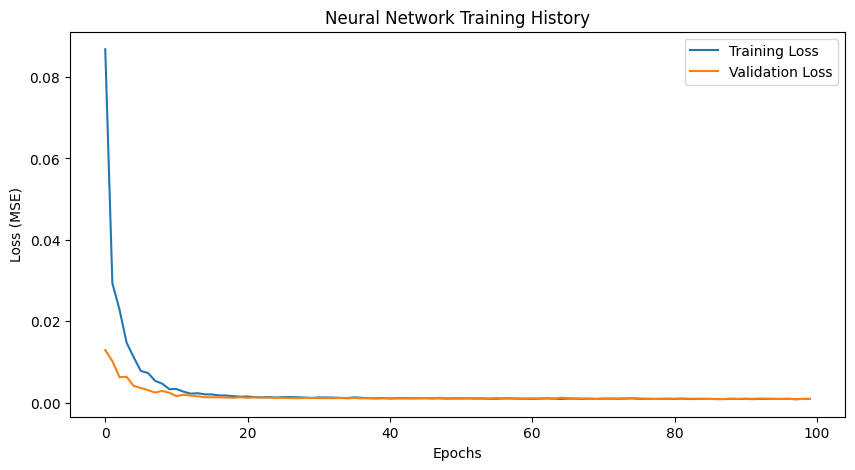

In [9]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Neural Network Training History')
plt.show()

Residual Distributions

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


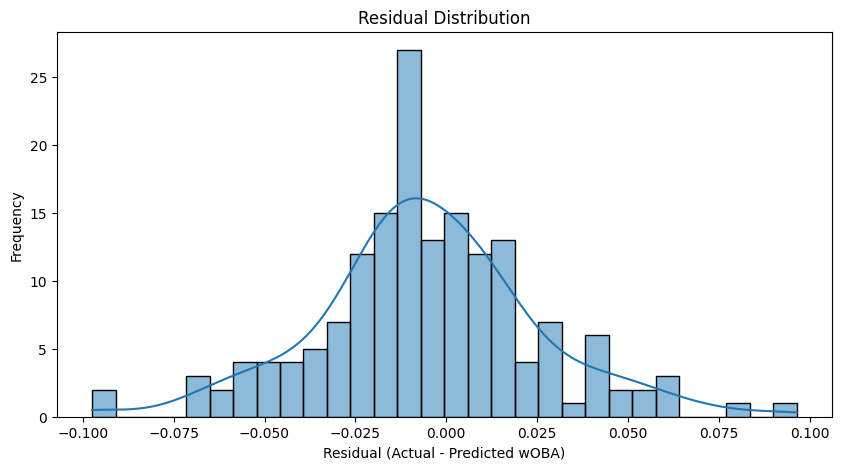

In [10]:
# Predictions
y_pred = model.predict(X_test).flatten()
residuals = y_test - y_pred

# Plot Residual Distribution
plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel("Residual (Actual - Predicted wOBA)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


Make Prediction

In [11]:
import pandas as pd
import numpy as np
import joblib
from pybaseball import batting_stats
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from sklearn.preprocessing import StandardScaler

# Load the trained model
model = load_model("wOBA_NN_model.h5", custom_objects={
    "mse": MeanSquaredError(),
    "mae": MeanAbsoluteError()
})

# Load the trained scaler (ensures consistent feature scaling)
scaler = joblib.load("scaler.pkl")

# Define feature order (must match training features exactly)
FEATURES = [
    "WPA/LI", "REW", "RE24", "xSLG", "Off", "EV", "wRAA", "ISO+",
    "max_exit_velocity", "BB_K_Ratio", "WPA", "Speed_Impact",
    "rel_wOBA", "rel_ISO", "rel_EV", "rel_OBP", "rel_SLG",
    "rel_hard_hit_rate", "Age", "wOBA_change", "weighted_wOBA_3Y",
    "weighted_wOBA_5Y", "age_decline_factor"
]

# Define rolling weight factors
weights_3Y = [0.5, 0.3, 0.2]
weights_5Y = [0.4, 0.25, 0.15, 0.1, 0.1]

def get_player_batting_data(player_name, start_year=2015, end_year=2023):
    """
    Fetches batting stats for a specific player from Fangraphs via pybaseball.
    """
    all_years_data = pd.concat(
        [batting_stats(year) for year in range(start_year, end_year + 1)],
        ignore_index=True
    )

    # Rename IDfg to player_id if needed
    if "IDfg" in all_years_data.columns:
        all_years_data.rename(columns={"IDfg": "player_id"}, inplace=True)

    # Handle missing hard hit rate
    if "HardHit%" in all_years_data.columns:
        all_years_data.rename(columns={"HardHit%": "hard_hit_rate"}, inplace=True)
    else:
        all_years_data["hard_hit_rate"] = 0

    if "maxEV" in all_years_data.columns:
        all_years_data.rename(columns={"maxEV": "max_exit_velocity"}, inplace=True)
    else:
        all_years_data["max_exit_velocity"] = 0

    # Compute BB/K Ratio
    if "BB%" in all_years_data.columns and "K%" in all_years_data.columns:
        all_years_data["BB_K_Ratio"] = all_years_data["BB%"] / all_years_data["K%"]
    else:
        all_years_data["BB_K_Ratio"] = 0

    # Compute Speed_Impact
    if "Spd" in all_years_data.columns:
        all_years_data["Speed_Impact"] = all_years_data["Spd"] * all_years_data["ISO+"]
    else:
        all_years_data["Speed_Impact"] = 0

    # Filter for the specific player
    player_data = all_years_data[all_years_data["Name"] == player_name].copy()

    if player_data.empty:
        print(f"⚠️ No data found for {player_name} in years {start_year}-{end_year}")
        return None

    # Ensure sorting for calculations
    player_data = player_data.sort_values(by=["player_id", "Season"])

    # Compute Year-over-Year wOBA Change
    player_data["wOBA_change"] = player_data.groupby("player_id")["wOBA"].diff()

    # Compute relative stats (compared to league average)
    league_avg = player_data.groupby("Season")[["wOBA", "ISO", "EV", "OBP", "SLG", "hard_hit_rate"]].mean()
    for stat in ["wOBA", "ISO", "EV", "OBP", "SLG", "hard_hit_rate"]:
        if stat in player_data.columns:
            player_data[f"rel_{stat}"] = player_data[stat] - player_data["Season"].map(league_avg[stat])
        else:
            player_data[f"rel_{stat}"] = 0

    # Compute weighted rolling averages
    def compute_weighted_rolling(df, col, weights):
        return df[col].rolling(len(weights), min_periods=len(weights)).apply(lambda x: np.dot(x, weights[-len(x):]), raw=True)

    if "wOBA" in player_data.columns:
        player_data["weighted_wOBA_3Y"] = compute_weighted_rolling(player_data, "wOBA", weights_3Y)
        player_data["weighted_wOBA_5Y"] = compute_weighted_rolling(player_data, "wOBA", weights_5Y)

    # Implement Age-Based Decline Factor
    def age_decline_factor(age):
        return 1 / (1 + np.exp((age - 30) / 3))

    player_data["age_decline_factor"] = player_data["Age"].apply(age_decline_factor)

    # Fill missing values
    player_data = player_data.fillna(0)

    # Extract the latest season's data for prediction
    latest_data = player_data[player_data["Season"] == end_year][FEATURES]

    if latest_data.empty:
        print(f"⚠️ No data for {player_name} in {end_year}. Using the latest available season.")
        latest_data = player_data.iloc[-1:][FEATURES]  # Use the last available season

    return latest_data

def predict_wOBA(player_name, model):
    """
    Fetches a player's data, processes it, scales it using the trained scaler,
    and makes a prediction with the neural network model.
    """
    player_features = get_player_batting_data(player_name)

    if player_features is None:
        return None

    # Convert to DataFrame (ensure correct format)
    player_features = pd.DataFrame(player_features, columns=FEATURES)

    # **Apply the same StandardScaler transformation used during training**
    player_features_scaled = scaler.transform(player_features.to_numpy())

    # Make prediction
    predicted_wOBA = model.predict(player_features_scaled)

    # Clip to valid wOBA range
    predicted_wOBA = np.clip(predicted_wOBA, 0.250, 0.450)

    print(f"🔮 Predicted wOBA for {player_name}: {predicted_wOBA[0][0]:.3f}")
    return predicted_wOBA[0][0]

# Example usage:
predicted_wOBA = predict_wOBA("Freddie Freeman", model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
🔮 Predicted wOBA for Freddie Freeman: 0.364


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
